#### 패키지 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### 변수 설정

In [2]:
trainGraphTitle = "Train Data"
testGraphTitle = "Test Data"
checkpointPath = "./weightCheckpoint/bestParam.hdf5"
loss = "mse" 

title = "ETC"
detail = "Candidate Parameter 8"
resultComment = f"{title} - {detail}"
fileSavePath = f"./result/{title}/{detail}"

depth = "SingleGRU" # Default
# depth = "DoubleGRU" 
# depth = "TripleGRU"

# 변수 "" 가 Default
hiddenState = 32 # units: 16 "32" 64
timeStep = 20 # input_length 10 "20" 40
activation = "tanh" # "tanh" sigmoid
epochs = 100 # 50 "100" 200
batchSize = 64 # 32 "64" 256
dataSize = 10 # 5 "10" 40
optimizer = "adam" # "adam" sgd
patience = 30 # 10 "30" 50

#### Pandas Setting

In [3]:
pd.set_option('display.max_rows', None) # row 생략 없이 출력
pd.set_option('display.max_columns', None) # col 생략 없이 출력

#### Data Load

In [4]:
apple = pd.read_csv("Apple_5Y.csv")

if dataSize == 10:
    apple = pd.read_csv("Apple_10Y.csv")
elif dataSize == 40:
    apple = pd.read_csv("Apple_Whole_Period.csv")

#### Describe 확인

In [5]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,1.060200e+04
mean,16.470998,16.658052,16.284922,16.477925,15.807495,3.276539e+08
std,35.131697,35.556418,34.715065,35.150839,34.824451,3.378635e+08
min,0.049665,0.049665,0.049107,0.049107,0.038213,0.000000e+00
25%,0.287338,0.294643,0.280759,0.287338,0.237548,1.213772e+08
50%,0.486607,0.493304,0.477679,0.486049,0.402768,2.146984e+08
75%,16.130179,16.309196,15.966607,16.095179,13.919097,4.067266e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,7.421641e+09


#### trainData, testData 가공

In [6]:
def transformData(data: [[float]]):
    # 날짜 제외
    data = data.drop(columns=["Date"])

    # 데이터 분리 test: 200개와 나머지
    trainSet = data[ : -200]
    testSet = data[-200 : ]
    
    # 데이터 0~1로 정규화
    sc = MinMaxScaler(feature_range=(0, 1)) 
    sc.fit(trainSet)
    trainSet = sc.transform(trainSet)
    testSet = sc.transform(testSet)
    
    # trainX, trainY, testX, testY 분리
    def parsingData(dataSet: [[float]]) -> ([[[float]]], [[float]]):
        dataX, dataY = [], []
        for index in range(len(dataSet) - timeStep):
            temp = []
            for step in range(timeStep):
                temp.append(dataSet[index + step])
            dataX.append(temp)
            dataY.append(dataSet[index + timeStep])

        return np.array(dataX), np.array(dataY)

    trainDataX, trainDataY = parsingData(trainSet)
    testDataX, testDataY = parsingData(testSet)
    
    
    return trainDataX, trainDataY, testDataX[:-30], testDataY, sc

#### Data Parsing

In [7]:
trainX, trainY, testX, testY, scaler = transformData(apple)

#### Model Implementation

In [8]:
model = Sequential()

if depth == "SingleGRU":
    model.add(
    GRU(
        units = hiddenState,
        input_length = trainX.shape[1],
        input_dim = trainX.shape[2],
        activation = activation
        )
    )
    model.add(Dense(6))
    
    
    
    
elif depth == "DoubleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
    
elif depth == "TripleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))

model.summary()

Metal device set to: Apple M1


2023-01-05 21:00:29.375023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 21:00:29.375167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 16)            1152      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 2,886
Trainable params: 2,886
Non-trainable params: 0
_________________________________________________________________


#### Model Complie

In [9]:
model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = ["mae"]
)

#### Model Training

In [10]:
earlyStop = EarlyStopping(
    monitor = 'loss',
    min_delta = 0.0001,
    patience = patience,
    verbose = 1
)
saveBest = ModelCheckpoint(
    filepath = checkpointPath,
    monitor = "loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
    save_freq = "epoch"
)

fitStartTime = time.time()
history = model.fit(
    trainX,
    trainY,
    epochs = epochs,
    batch_size = batchSize,
    callbacks = [earlyStop, saveBest]
)
fitEndTime = time.time()


model.load_weights(checkpointPath)

Epoch 1/100


2023-01-05 21:00:29.770952: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 21:00:30.923635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:00:31.091411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:00:31.193516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:00:31.347088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/324 [..............................] - ETA: 8s - loss: 0.0437 - mae: 0.0821  

2023-01-05 21:00:31.487774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


324/324 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0233
Epoch 1: loss improved from inf to 0.00289, saving model to ./weightCheckpoint/bestParam.hdf5
324/324 [==============================] - 10s 26ms/step - loss: 0.0029 - mae: 0.0233
Epoch 2/100
323/324 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0163
Epoch 2: loss improved from 0.00289 to 0.00118, saving model to ./weightCheckpoint/bestParam.hdf5
324/324 [==============================] - 8s 26ms/step - loss: 0.0012 - mae: 0.0163
Epoch 3/100
323/324 [============================>.] - ETA: 0s - loss: 3.2125e-04 - mae: 0.0079
Epoch 3: loss improved from 0.00118 to 0.00032, saving model to ./weightCheckpoint/bestParam.hdf5
324/324 [==============================] - 9s 27ms/step - loss: 3.2105e-04 - mae: 0.0079
Epoch 4/100
323/324 [============================>.] - ETA: 0s - loss: 2.7193e-04 - mae: 0.0075
Epoch 4: loss improved from 0.00032 to 0.00027, saving model to ./weightCheckpoint/bes

324/324 [==============================] - ETA: 0s - loss: 1.5985e-04 - mae: 0.0054
Epoch 33: loss did not improve from 0.00015
324/324 [==============================] - 9s 27ms/step - loss: 1.5985e-04 - mae: 0.0054
Epoch 34/100
323/324 [============================>.] - ETA: 0s - loss: 1.5426e-04 - mae: 0.0051
Epoch 34: loss did not improve from 0.00015
324/324 [==============================] - 9s 27ms/step - loss: 1.5436e-04 - mae: 0.0051
Epoch 35/100
324/324 [==============================] - ETA: 0s - loss: 1.5751e-04 - mae: 0.0052
Epoch 35: loss did not improve from 0.00015
324/324 [==============================] - 9s 27ms/step - loss: 1.5751e-04 - mae: 0.0052
Epoch 36/100
324/324 [==============================] - ETA: 0s - loss: 1.5197e-04 - mae: 0.0050
Epoch 36: loss did not improve from 0.00015
324/324 [==============================] - 8s 25ms/step - loss: 1.5197e-04 - mae: 0.0050
Epoch 37/100
324/324 [==============================] - ETA: 0s - loss: 1.5242e-04 - mae: 0.0

322/324 [============================>.] - ETA: 0s - loss: 1.4946e-04 - mae: 0.0055
Epoch 68: loss did not improve from 0.00015
324/324 [==============================] - 8s 25ms/step - loss: 1.4930e-04 - mae: 0.0054
Epoch 69/100
324/324 [==============================] - ETA: 0s - loss: 1.4828e-04 - mae: 0.0055
Epoch 69: loss did not improve from 0.00015
324/324 [==============================] - 8s 26ms/step - loss: 1.4828e-04 - mae: 0.0055
Epoch 70/100
324/324 [==============================] - ETA: 0s - loss: 1.4761e-04 - mae: 0.0054
Epoch 70: loss did not improve from 0.00015
324/324 [==============================] - 8s 25ms/step - loss: 1.4761e-04 - mae: 0.0054
Epoch 71/100
324/324 [==============================] - ETA: 0s - loss: 1.4997e-04 - mae: 0.0055
Epoch 71: loss did not improve from 0.00015
324/324 [==============================] - 8s 25ms/step - loss: 1.4997e-04 - mae: 0.0055
Epoch 72/100
324/324 [==============================] - ETA: 0s - loss: 1.4968e-04 - mae: 0.0

#### 이후 30일 예측

In [11]:
thirtyPredict = testX

for _ in range(30):
    currentPredict = model.predict(thirtyPredict)
    recentPredict = np.reshape(currentPredict[-1], (1, currentPredict[-1].shape[0]))
    newPredictStep = thirtyPredict[-1, 1:]
    nextPredict = np.append(newPredictStep, recentPredict, axis = 0)
    nextPredict = np.reshape(nextPredict, (1, nextPredict.shape[0], nextPredict.shape[1]))
    thirtyPredict = np.append(thirtyPredict, nextPredict, axis = 0)

2023-01-05 21:14:39.804344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:14:39.856499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:14:39.940684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 38ms/step


#### 결과 기록

In [12]:
fitTime = fitEndTime - fitStartTime
score = model.evaluate(testX, testY[:-30])
predictScore = model.evaluate(thirtyPredict[-30:], testY[-30:])
parameters = f"""
layer = {depth}
hiddenState = {hiddenState}
timeStep = {timeStep}
activation = {activation}
epochs = {epochs}
batchSize = {batchSize}
dataSize = {dataSize}
optimizer = {optimizer}
patience = {patience}
"""

f = open("result.txt", "a")
f.write(f"{resultComment}\n모델 학습 시간: {fitTime:.3} sec\n평가 손실: {score[0]:.6}\n30일 예측 손실: {predictScore[0]:.6}\n{parameters}\n--------------------------------------\n\n")
f.close()

2023-01-05 21:14:46.618168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:14:46.676858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 21:14:46.754428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 141ms/step - loss: 0.0065 - mae: 0.0611


In [13]:
print(f"모델 학습 시간: {fitTime:.3} sec")

모델 학습 시간: 8.5e+02 sec


In [14]:
print(f"평가 손실: {score[0]}")

평가 손실: 0.0007412161212414503


In [15]:
print(f"30일 예측 손실: {predictScore[0]}")

30일 예측 손실: 0.006455305963754654


#### Test Data 예측 및 역정규화

In [16]:
trainPrediction = scaler.inverse_transform(model.predict(trainX))
testPrediction = scaler.inverse_transform(model.predict(testX))

inversingTrainY = scaler.inverse_transform(trainY)
inversingTestY = scaler.inverse_transform(testY)

5/5 [==============================] - 0s 17ms/step


### 그래프

#### Loss

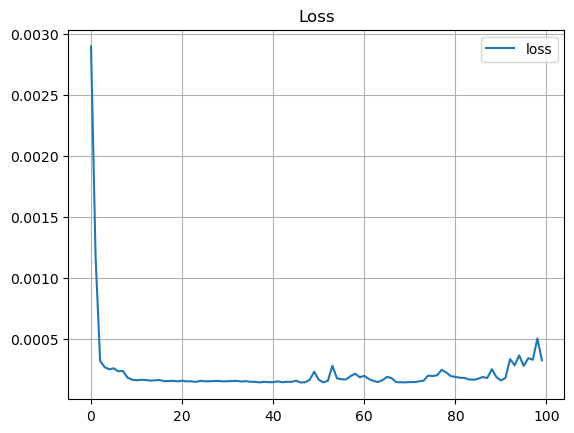

In [17]:
loss = history.history["loss"]
plt.title("Loss")
plt.plot(loss, label="loss")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Loss.png")
plt.legend()
plt.show()

#### Train Data Graph

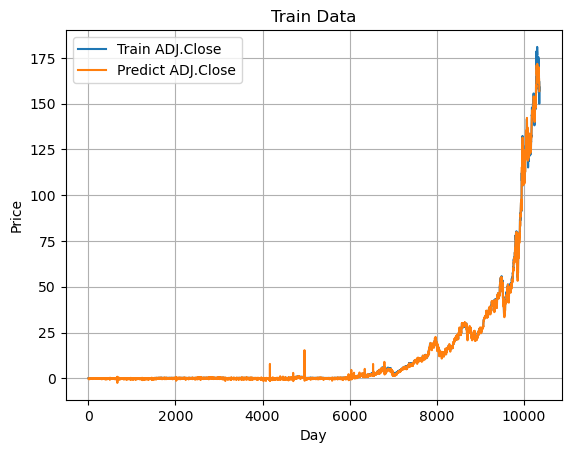

In [18]:
plt.title(trainGraphTitle)
plt.plot(inversingTrainY[:, 4], label="Train ADJ.Close")
plt.plot(trainPrediction[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Train.png")
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Test Data Graph

In [19]:
# plt.title(testGraphTitle)
# plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
# plt.plot(testPrediction[:, 4], label="Predict ADJ.Close")
# plt.grid(True)
# plt.xlabel('Day')
# plt.ylabel('Price')
# plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
# plt.legend()
# plt.savefig(f"{fileSavePath}/Test.png")
# plt.show()

#### Test Data + 30일 예측 그래프

5/5 [==============================] - 0s 15ms/step


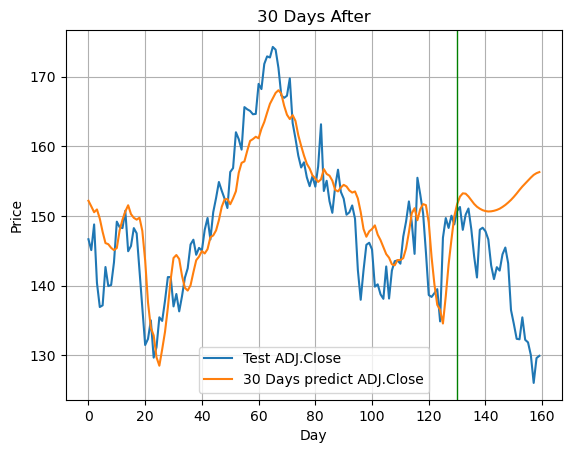

In [20]:
thirtyDaysAfterpredict = scaler.inverse_transform(model.predict(thirtyPredict))

plt.title("30 Days After")
plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
plt.plot(thirtyDaysAfterpredict[:, 4], label="30 Days predict ADJ.Close")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Price')
plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
plt.legend()
plt.savefig(f"{fileSavePath}/30Predict.png")
plt.show()